# Short intro to Bayesian update

This notebook generates the plots for the presentation "Short intro to Bayesian update".

It also serves the purpose of verifying you have all the required libraries installed. Run this notebook and make sure you don't get any errors. Also, you should see a diagram at the end of the notebook.

**Don't worry if you don't understand the code.** This is just to make sure everything is working as expected.


## ّRequired libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
from plot_utils import MY_COLORS

## Define some prior distributions

In [2]:
# uniform prior
b1 = beta(1, 1)
# bell-shaped prior
b2 = beta(5, 5)
# over-confident bell shaped
b3 = beta(20, 140)
# u-shaped prior
b4 = beta(0.5, 0.5)
dists = {
    "Uniform": b1,
    "Bell-shaped": b2,
    "U-shaped": b4,
    "Over-confident": b3,
}

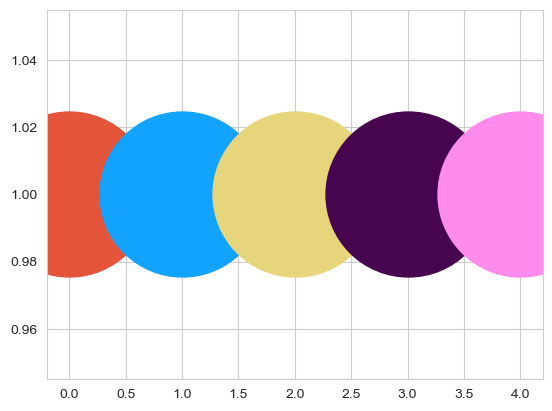

In [3]:
for i, c in enumerate(MY_COLORS):
    plt.scatter([i], [1], s=14100, color=c)

You should see a plot with 5 different colors. If you see that, you are good to go.

In [4]:
def plot_pdfs(dists):
    x = np.linspace(0, 1, 100)
    fig, axes = plt.subplots(
        nrows=len(dists), sharex=True, sharey=False, figsize=(8, 12), dpi=120
    )
    for ax, (name, d) in zip(reversed(axes), dists.items()):
        ax.plot(x, d.pdf(x), lw=2, color=MY_COLORS[0])
        ax.set_yticklabels([])
        sns.despine(left=True, ax=ax)
        ax.set_ylabel(name, rotation=0, labelpad=20, y=0.8, ha="right")
        ax.grid(False)
    ax = axes[-1]
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(ax.get_xticks(), fontsize=18)
    return fig

In [5]:
def get_updated_dists(dists, where: str):
    assert where in {"above", "below"}
    for name, d in dists.items():
        args = list(d.args)
        if where == "below":
            args[0] += 1
        else:
            args[1] += 1
        dists[name] = beta(*args)
    return dists

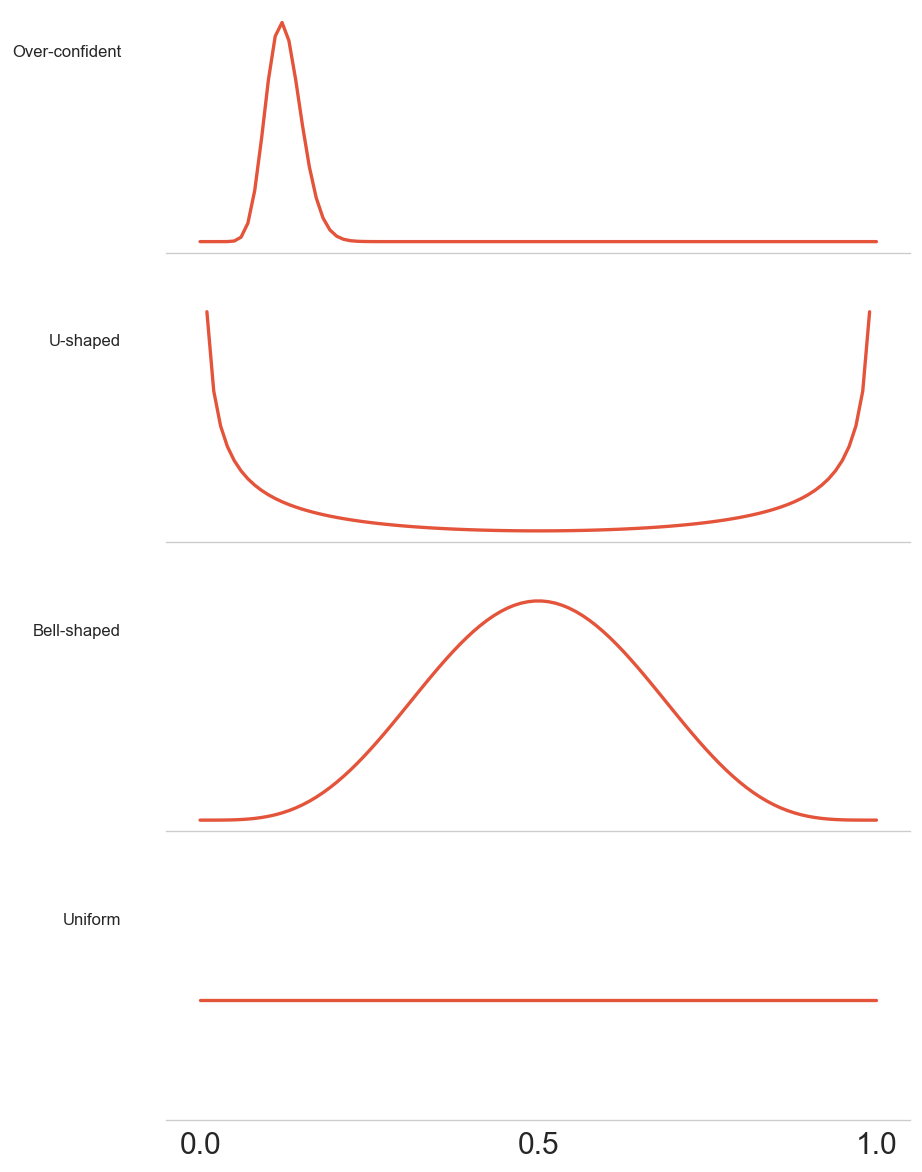

In [6]:
fig = plot_pdfs(dists)

You should see a plot with 4 different prior distributions. If you see that, you are good to go.

## Update the distributions

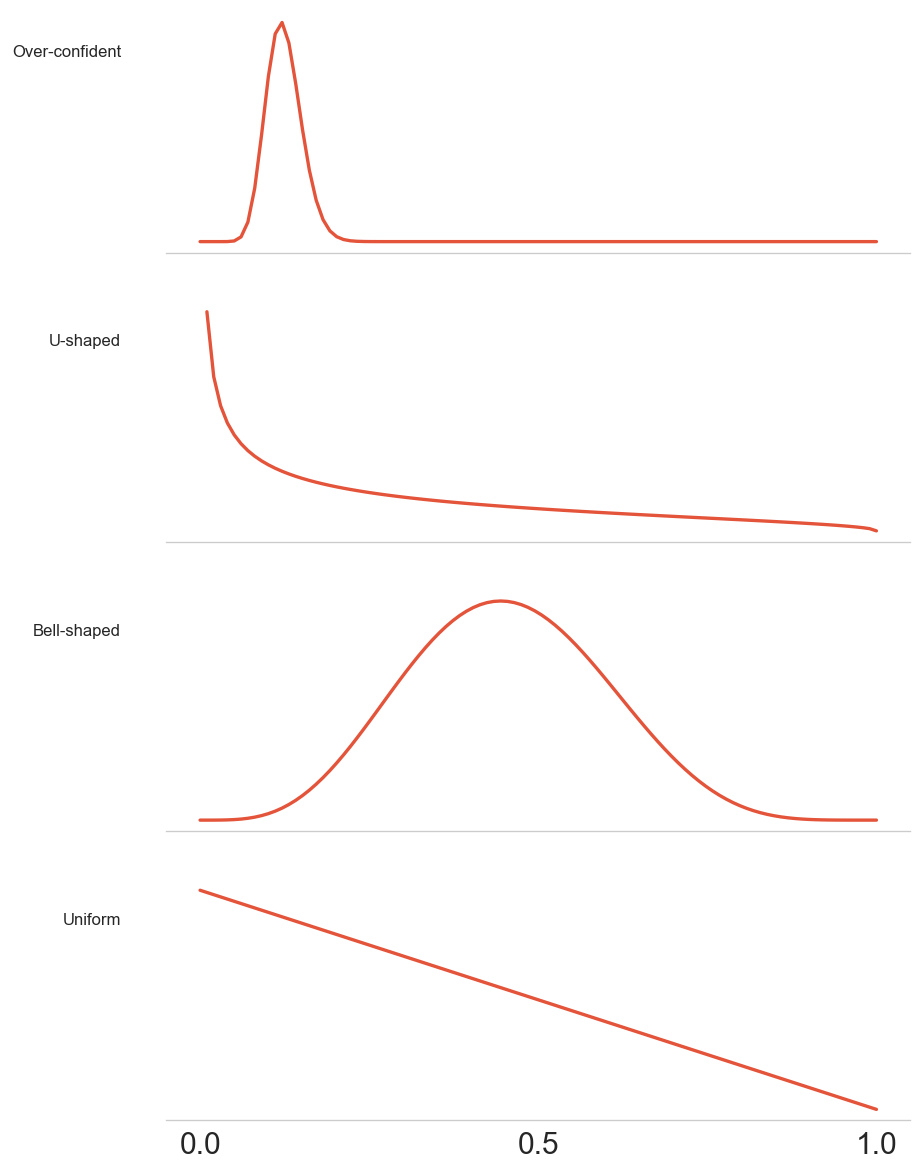

In [7]:
dists = get_updated_dists(dists, "above")
fig = plot_pdfs(dists)

You should see a plot with 4 distributions that differ from the previous plot. If you see that, you are good to go.

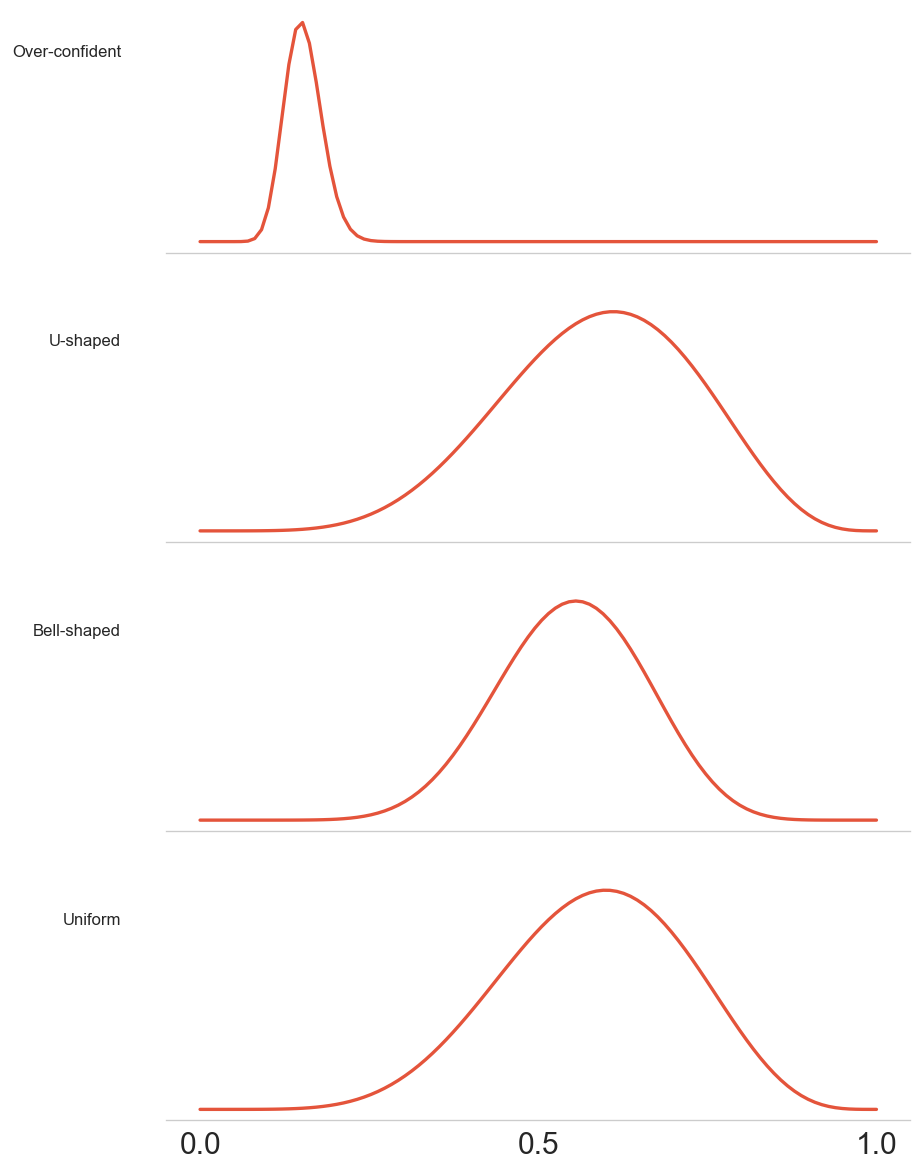

In [8]:
more_updates = """
Above
Above
Below
Below
Below
Above
Below
Below
Below
""".splitlines()
more_updates = [l.lower().strip() for l in more_updates if l.strip()]
for update in more_updates:
    dists = get_updated_dists(dists, update)
fig = plot_pdfs(dists)

In [9]:
p_above = (more_updates.count("above") + 1) / (len(more_updates) + 2)
np.random.seed(42)
n_samples = 10000
samples = np.random.rand(n_samples)
observed = samples < p_above

## Bayesian update

The cells below might take time to run, especially when you run them for the first time.

In [10]:
import pymc as pm  # for modelling
import arviz as az  # for plotting

In [11]:
with pm.Model() as model:
    # you can try any of the priors above
    # p = pm.Beta('p', alpha=1, beta=1) # uniform prior
    # p = pm.Beta('p', alpha=5, beta=5) # bell-shaped prior
    p = pm.Beta("p", alpha=20, beta=140)  # over-confident prior
    # p = pm.Beta('p', alpha=0.5, beta=0.5) # u-shaped prior

We are using context managers (`with`) to make sure the variables are defined within the model. PyMC requires this to work properly. For demonstration purposes, we split the model creation in several cells. As a consequence, you can't run the cells below multiple times without re-running the first `with` cell above.

In [12]:
# prior distribution, no data
with model:
    prior_trace = pm.sample(n_samples, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 1 seconds.


The plot below shows the prior distribution before observing any data. The vertical line shows the true value of $p$. You can go back to the previous cells and change the prior to see how it affects the curve below.

Text(0.5, 1.0, 'Prior\n(Before data is observed)')

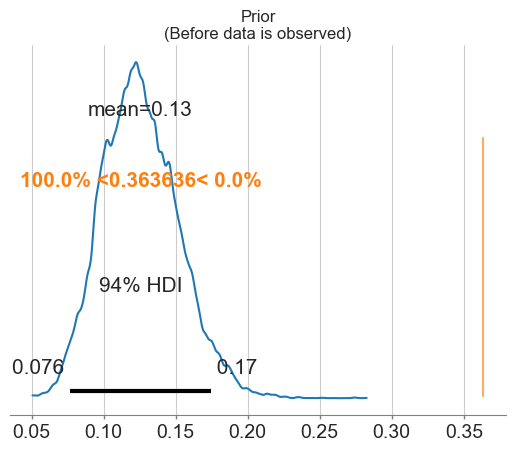

In [13]:
ax = az.plot_posterior(prior_trace, ref_val=p_above)
ax.set_title("Prior\n(Before data is observed)")

Now, we'll update the distributions with the data we generated above. **You'll see quite a few warnings below.** You can ignore them.

In [14]:
# update the prior with the data
with model:
    likelihood = pm.Bernoulli("likelihood", p, observed=observed)
    posterior_trace = pm.sample(n_samples, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Output()

/Users/boris/miniconda3/envs/bayesian/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/boris/miniconda3/envs/bayesian/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/boris/miniconda3/envs/bayesian/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/boris/miniconda3/envs/bayesian/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 1 seconds.


Plot the posterior distribution after observing the data

Text(0.5, 1.0, 'Posterior\n(After seeing 10,000 data points)')

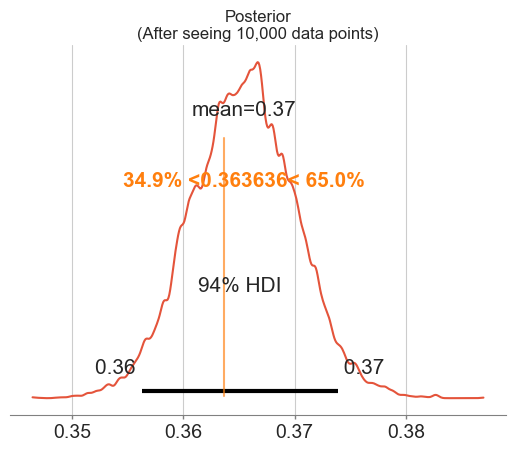

In [15]:
# plot the posterior
ax = az.plot_posterior(posterior_trace, color=MY_COLORS[0], ref_val=p_above)
ax.set_title(
    f"Posterior\n(After seeing {len(samples):,} data points)".format(n_samples)
)

Additional useful plots

array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

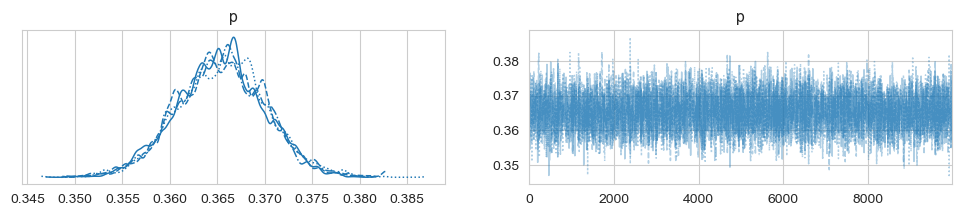

In [16]:
az.plot_trace(posterior_trace)

<Axes: title={'center': 'p'}>

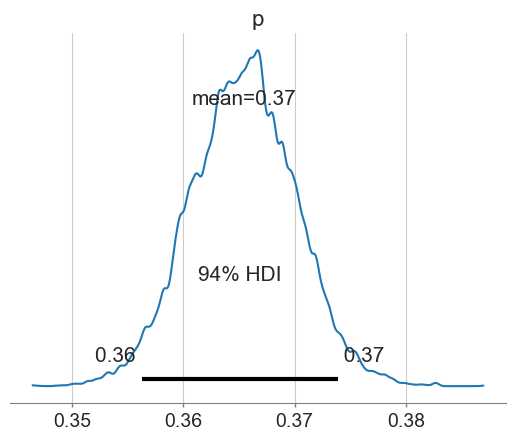

In [17]:
az.plot_posterior(posterior_trace, var_names=["p"])

<Axes: title={'center': 'p'}>

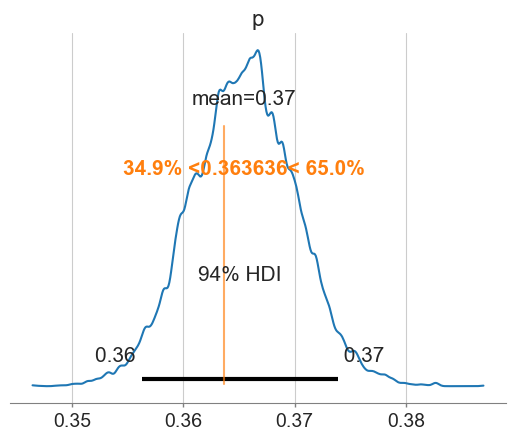

In [18]:
az.plot_posterior(posterior_trace, var_names=["p"], ref_val=p_above)

We can use graphviz to visualize the model

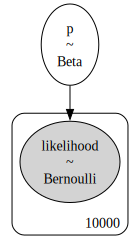

In [19]:
pm.model_to_graphviz(model)

The cell above should show a small black-and-white block diagram. If it runs without any errors but you still can't see the diagram, try appending `.view()` (`pm.model_to_graphviz(model).view()`) to the last line of the cell above. This will open the diagram in a new window.